## VCB

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adadelta')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1568 - val_loss: 0.7450
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1498 - val_loss: 0.7104
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1429 - val_loss: 0.6765
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1361 - val_loss: 0.6432
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1294 - val_loss: 0.6104
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1228 - val_loss: 0.5782
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1163 - val_loss: 0.5465
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1100 - val_loss: 0.5154
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1037 - val_loss: 0.4848
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0976 - val_loss: 0.4547
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0916 - val_loss: 0.4252
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0857 - val_lo

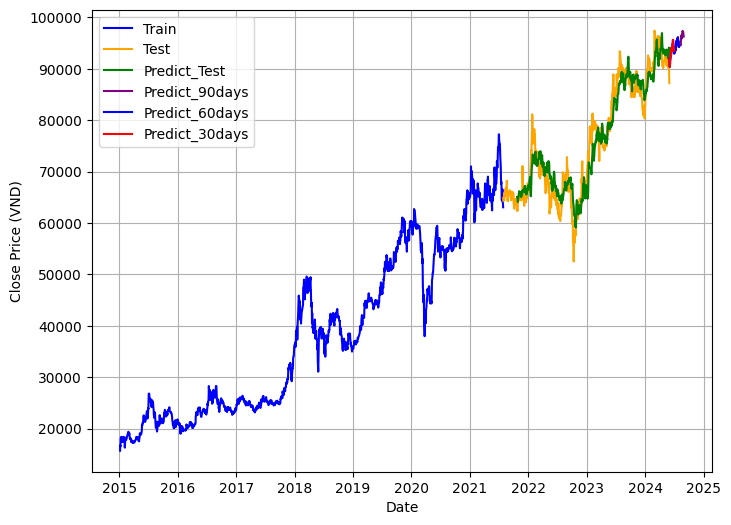

In [29]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [30]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  91857.828125
2024-06-02  91210.218750
2024-06-03  90378.093750
2024-06-04  90722.726562
2024-06-05  91619.414062
...                  ...
2024-08-25  97155.648438
2024-08-26  97171.953125
2024-08-27  96748.937500
2024-08-28  96446.671875
2024-08-29  96255.617188

[90 rows x 1 columns]


In [31]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 3066.9398251402886
MAPE: 3.2182030884770536 %
MAE: 2398.455577054128


## CTG

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,)))
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adadelta')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/100


c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - loss: 0.0068 
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.0063
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.0060
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0057
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.0055
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.0053
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.0052
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.0051
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.0050
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 0.0049
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.0048
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.0048
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0047
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.0046
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step 

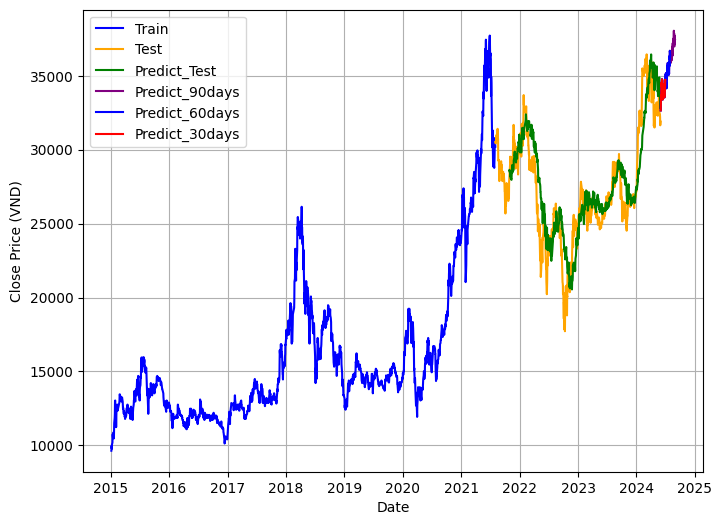

In [33]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [34]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast CTG stock prices for the next 90 days:")
print(future_df)


Forecast CTG stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  32662.007812
2024-06-02  33101.230469
2024-06-03  33695.828125
2024-06-04  33485.843750
2024-06-05  34518.753906
...                  ...
2024-08-25  36979.507812
2024-08-26  37718.394531
2024-08-27  37147.582031
2024-08-28  37381.890625
2024-08-29  37428.675781

[90 rows x 1 columns]


In [35]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1765.6248089433188
MAPE: 5.097082496339444 %
MAE: 1340.1117496845884


## BID

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (70/30) 
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,)))
model.add(Dense(50, activation='relu'))                          
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adadelta')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/100


c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - loss: 0.3407 
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.3297
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.3186
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.3076
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.2965
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.2855
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.2745
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.2637
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.2530
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.2425
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.2322
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.2221
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 0.2123
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.2028
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step 

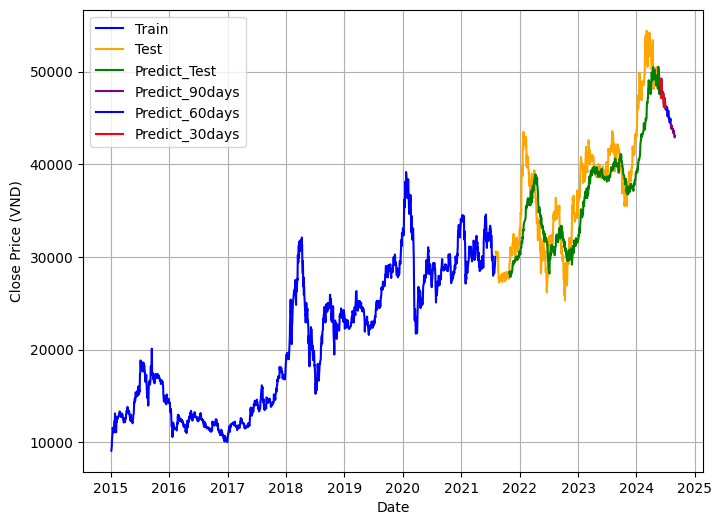

In [37]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using MLP 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [38]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast BID stock prices for the next 90 days:")
print(future_df)


Forecast BID stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  48260.980469
2024-06-02  48363.750000
2024-06-03  48679.671875
2024-06-04  49221.511719
2024-06-05  48985.597656
...                  ...
2024-08-25  43173.867188
2024-08-26  42969.500000
2024-08-27  42902.234375
2024-08-28  42903.246094
2024-08-29  43021.136719

[90 rows x 1 columns]


In [39]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 3330.2540746588247
MAPE: 6.8126120377354935 %
MAE: 2620.9237735345496
